# Project Name

## Group Members and Contributions

 - Chiehkun (Timo) Chen
 - Jordan Daley
 - Jacob Moul, PID: A13548393
 - Hannah Peterson, A13724073
 - Yun (Denise) Tang
 - George Thomas


## Introduction and Background

### Background Research

### Research Question

Question: Did the 2011-19 drought in California disproportionately affect low-income communities?

This project will examine the impacts of climate change on low-income communities (specifically through the climatic event of drought). We will focus on California, because it has experienced prolonged drought within the past decade (for 376 consecutive weeks—Dec 2011 - March 2019). In particular, we will investigate whether or not the California drought has had disproportionate negative effects on low-income communities compared to average and high-income communities. This question is important because as the effects of global warming become more severe, efforts must be made to protect communities that are most vulnerable to these negative effects.

To answer this question we are planning on analyzing different indicators of economic well being and different effects of drought for various communities over time, from before during and after the most recent drought. For example, we plan to investigate the relationships between income in communities and costs associated with the drought, such as utility rates, as well as potential health issues, such as respiratory illnesses, that are known to increase in conjunction with drought.

### Hypothesis

Hypothesis: The 2011-19 drought in California did disproportionately affect low-income communities.

We expect to find that these communities will have suffered more than relatively better-off communities because they have fewer safeguards to deal with environmental events, and also have less means to bear the cost of higher utility or healthcare rates, for example. 

## Data

### Data Sets

**Community Economic Data**
 - Data Set Name: 'cbp[yr]co.txt' (For years 2012-2016)
      - We modified these files to include only observations for California, and they have been renamed 'cbp[yr]co_mod.csv'
 - Source: https://www.census.gov/programs-surveys/cbp/data/datasets.html

> These data sets are County Business Pattern data sets, and are provided with the description: “This series includes the number of establishments, employment during the week of March 12, first quarter payroll, and annual payroll. This data is useful for studying the economic activity of small areas; analyzing economic changes over time; and as a benchmark for other statistical series, surveys, and databases between economic censuses”. After being condensed to just the state of California, the 2016 data set (out of many others) is composed of 36616 observations of 26 variables, several of which are identifying information such as state or county code. In addition, it contains values for first quarter payroll, annual payroll, and number of employees, among other variables, for different industries in each county of California. This data comes from the US Census Bureau. All of these data sets are downloadable in csv format.


## Data Cleaning/Pre-Processing

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
### Import County Business Patterns Data, add year to each table

cbp00 = pd.read_csv('Data/cb_patterns/cbp00co_mod.csv')
cbp01 = pd.read_csv('Data/cb_patterns/cbp01co_mod.csv')
cbp02 = pd.read_csv('Data/cb_patterns/cbp02co_mod.csv')
cbp03 = pd.read_csv('Data/cb_patterns/cbp03co_mod.csv')
cbp04 = pd.read_csv('Data/cb_patterns/cbp04co_mod.csv')
cbp05 = pd.read_csv('Data/cb_patterns/cbp05co_mod.csv')
cbp06 = pd.read_csv('Data/cb_patterns/cbp06co_mod.csv')
cbp07 = pd.read_csv('Data/cb_patterns/cbp07co_mod.csv')
cbp08 = pd.read_csv('Data/cb_patterns/cbp08co_mod.csv')
cbp09 = pd.read_csv('Data/cb_patterns/cbp09co_mod.csv')
cbp10 = pd.read_csv('Data/cb_patterns/cbp10co_mod.csv')
cbp11 = pd.read_csv('Data/cb_patterns/cbp11co_mod.csv')
cbp12 = pd.read_csv('Data/cb_patterns/cbp12co_mod.csv')
cbp13 = pd.read_csv('Data/cb_patterns/cbp13co_mod.csv')
cbp14 = pd.read_csv('Data/cb_patterns/cbp14co_mod.csv')
cbp15 = pd.read_csv('Data/cb_patterns/cbp15co_mod.csv')
cbp16 = pd.read_csv('Data/cb_patterns/cbp16co_mod.csv')

cbp00['year'] = 2000
cbp01['year'] = 2001
cbp02['year'] = 2002
cbp03['year'] = 2003
cbp04['year'] = 2004
cbp05['year'] = 2005
cbp06['year'] = 2006
cbp07['year'] = 2007
cbp08['year'] = 2008
cbp09['year'] = 2009
cbp10['year'] = 2010
cbp11['year'] = 2011
cbp12['year'] = 2012
cbp13['year'] = 2013
cbp14['year'] = 2014
cbp15['year'] = 2015
cbp16['year'] = 2016

cbp_data = [cbp00, cbp01, cbp02, cbp03, cbp04, cbp05, cbp06, cbp07, cbp08, 
            cbp09, cbp10, cbp11, cbp12, cbp13, cbp14, cbp15, cbp16]

In [4]:
### Wrangle data

# Variables to be used in CBP analysis, fips is combined state and county code; for others, see county_layout_2015.txt
cbp_vars = ['fips', 'emp', 'ap', 'est', 'year']

simplified_cbp_data = []

for df in cbp_data:    
    # reformat FIPS county code for merging
    df[['fipstate', 'fipscty']] = df[['fipstate', 'fipscty']].astype(str)
    df['fips'] = df.fipstate.str.zfill(2) + df.fipscty.str.zfill(3)
    
    # select aggregate county data
    df = df[df.naics == '------']
    
    # drop unneccesary columns
    df = df[cbp_vars]
    
    simplified_cbp_data.append(df)

In [5]:
cbp_final = pd.concat(simplified_cbp_data).reset_index(drop=True)
cbp_final = cbp_final.rename(columns={'fips': 'FIPS', 'emp': 'Employment', 'ap': 'Annual Payroll', 
                                      'est': 'Establishments', 'year': 'Year'})

In [6]:
### Import and Wrangle Drought Data

# collect all drought file names
drought_files = glob.glob('Data/drought/*')

# import all drought tables
drought_data = []
for file in drought_files:
    drought_data.append(pd.read_csv(file))

simplified_drought_data = []

for df in drought_data:
    # add year column, reformat FIPS column for merging
    df['Year'] = pd.to_datetime(df.ValidStart).dt.year
    df['FIPS'] = df.FIPS.astype(str).str.zfill(5)
    
    # make sure only CA data included
    df = df[df.FIPS.str[:2] == '06'].reset_index(drop=True)
    
    # average drought index per county per year
    by_year = df.groupby(['FIPS', 'County'])[['None', 'D0', 'D1', 'D2', 'D3', 'D4']].mean().reset_index()
    by_year['Year'] = df.Year[0]
    
    simplified_drought_data.append(by_year)

In [7]:
drought_final = pd.concat(simplified_drought_data)
drought_final = drought_final.rename(columns={'None': 'No Drought'})

In [8]:
### Import and Wrangle Unemployment Data

unemploy = pd.read_csv('Data/Local_Area_Unemployment_Statistics__LAUS___Annual_Average.csv')

# select county unemployment data
unemploy = unemploy[(unemploy['Area Type'] == 'County') & (unemploy['Year'] < 2017)]

# select desired variable
unemploy = unemploy[['Area Name', 'Year', 'Unemployment Rate']].reset_index(drop=True)

# rename columns for merging
unemploy = unemploy.rename(columns={'Area Name': 'County'})

In [9]:
### Merge Data Sets

first_merge = pd.merge(left=cbp_final, right=drought_final, left_on=['FIPS', 'Year'], right_on=['FIPS', 'Year'], how='outer')
project_df = pd.merge(left=first_merge, right=unemploy, left_on=['County', 'Year'], right_on=['County', 'Year'])
project_df.head(100)

,FIPS,Employment,Annual Payroll,Establishments,Year,County,No Drought,D0,D1,D2,D3,D4,Unemployment Rate
0,06001,655730,28627936,36391,2000,Alameda County,97.862500,2.137500,0.000000,0.000000,0.000000,0.0,3.6
1,06003,1048,13362,52,2000,Alpine County,94.659423,5.340577,0.000000,0.000000,0.000000,0.0,6.3
2,06005,7378,174367,849,2000,Amador County,94.334038,5.665962,0.000000,0.000000,0.000000,0.0,5.2
3,06007,53776,1209766,4597,2000,Butte County,94.517885,5.482115,0.000000,0.000000,0.000000,0.0,6.2
4,06009,5757,125593,985,2000,Calaveras County,94.230769,5.769231,0.000000,0.000000,0.000000,0.0,5.6
5,06011,3430,88365,359,2000,Colusa County,95.938846,4.061154,0.000000,0.000000,0.000000,0.0,11.6
6,06013,315767,13548153,22065,2000,Contra Costa County,96.659423,3.340577,0.000000,0.000000,0.000000,0.0,3.6
7,06015,4395,87463,520,2000,Del Norte County,100.000000,0.000000,0.000000,0.000000,0.000000,0.0,7.4
8,06017,38215,1063125,3956,2000,El Dorado County,95.325769,4.674231,0.000000,0.000000,0.000000,0.0,4.1
9,06019,212950,5805236,15280,2000,Fresno County,90.484615,9.515385,0.000000,0.000000,0.000000,0.0,10.4


In [10]:
income_1999 = pd.read_csv('Data/income_by_county_1999.csv', header=1)
income_1999 = income_1999.iloc[:, 6:]
income_1999 = income_1999.rename(columns={income_1999.columns[0]: 'County', \
                                          income_1999.columns[2]: '% pop. in poverty'})
income_1999.head()

,County,Per capita income in 1999 (dollars),% pop. in poverty
0,California,22711,14.2
1,Alameda County,26680,11.0
2,Alpine County,24431,19.5
3,Amador County,22412,9.2
4,Butte County,17517,19.8


## Data Description

## Data Exploration

## Data Analysis

In [11]:
### Descriptive Analysis on Unemployment

##Central Tendency, Variability
project_df.describe()

,Employment,Annual Payroll,Establishments,Year,No Drought,D0,D1,D2,D3,D4,Unemployment Rate
count,9.860000e+02,9.860000e+02,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,2.264094e+05,1.098268e+07,14822.783976,2008.000000,42.027815,57.972185,42.710534,27.444563,14.475111,7.364515,8.810649
std,5.530495e+05,2.725970e+07,35173.618793,4.901466,40.470664,40.470664,41.357286,36.588673,31.578546,22.143001,3.878966
min,1.620000e+02,4.053000e+03,35.000000,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.900000
25%,8.930250e+03,2.605378e+05,915.750000,2004.000000,0.438019,9.456299,0.000000,0.000000,0.000000,0.000000,5.800000
50%,4.572900e+04,1.547160e+06,3914.000000,2008.000000,27.013113,72.986887,31.957075,1.740755,0.000000,0.000000,8.100000
75%,1.663308e+05,6.516260e+06,12078.750000,2012.000000,90.543701,99.561981,86.688538,52.830189,2.420755,0.000000,10.700000
max,4.007163e+06,2.128736e+08,269489.000000,2016.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,28.900000


In [12]:
##size
project_df.shape

(986, 13)

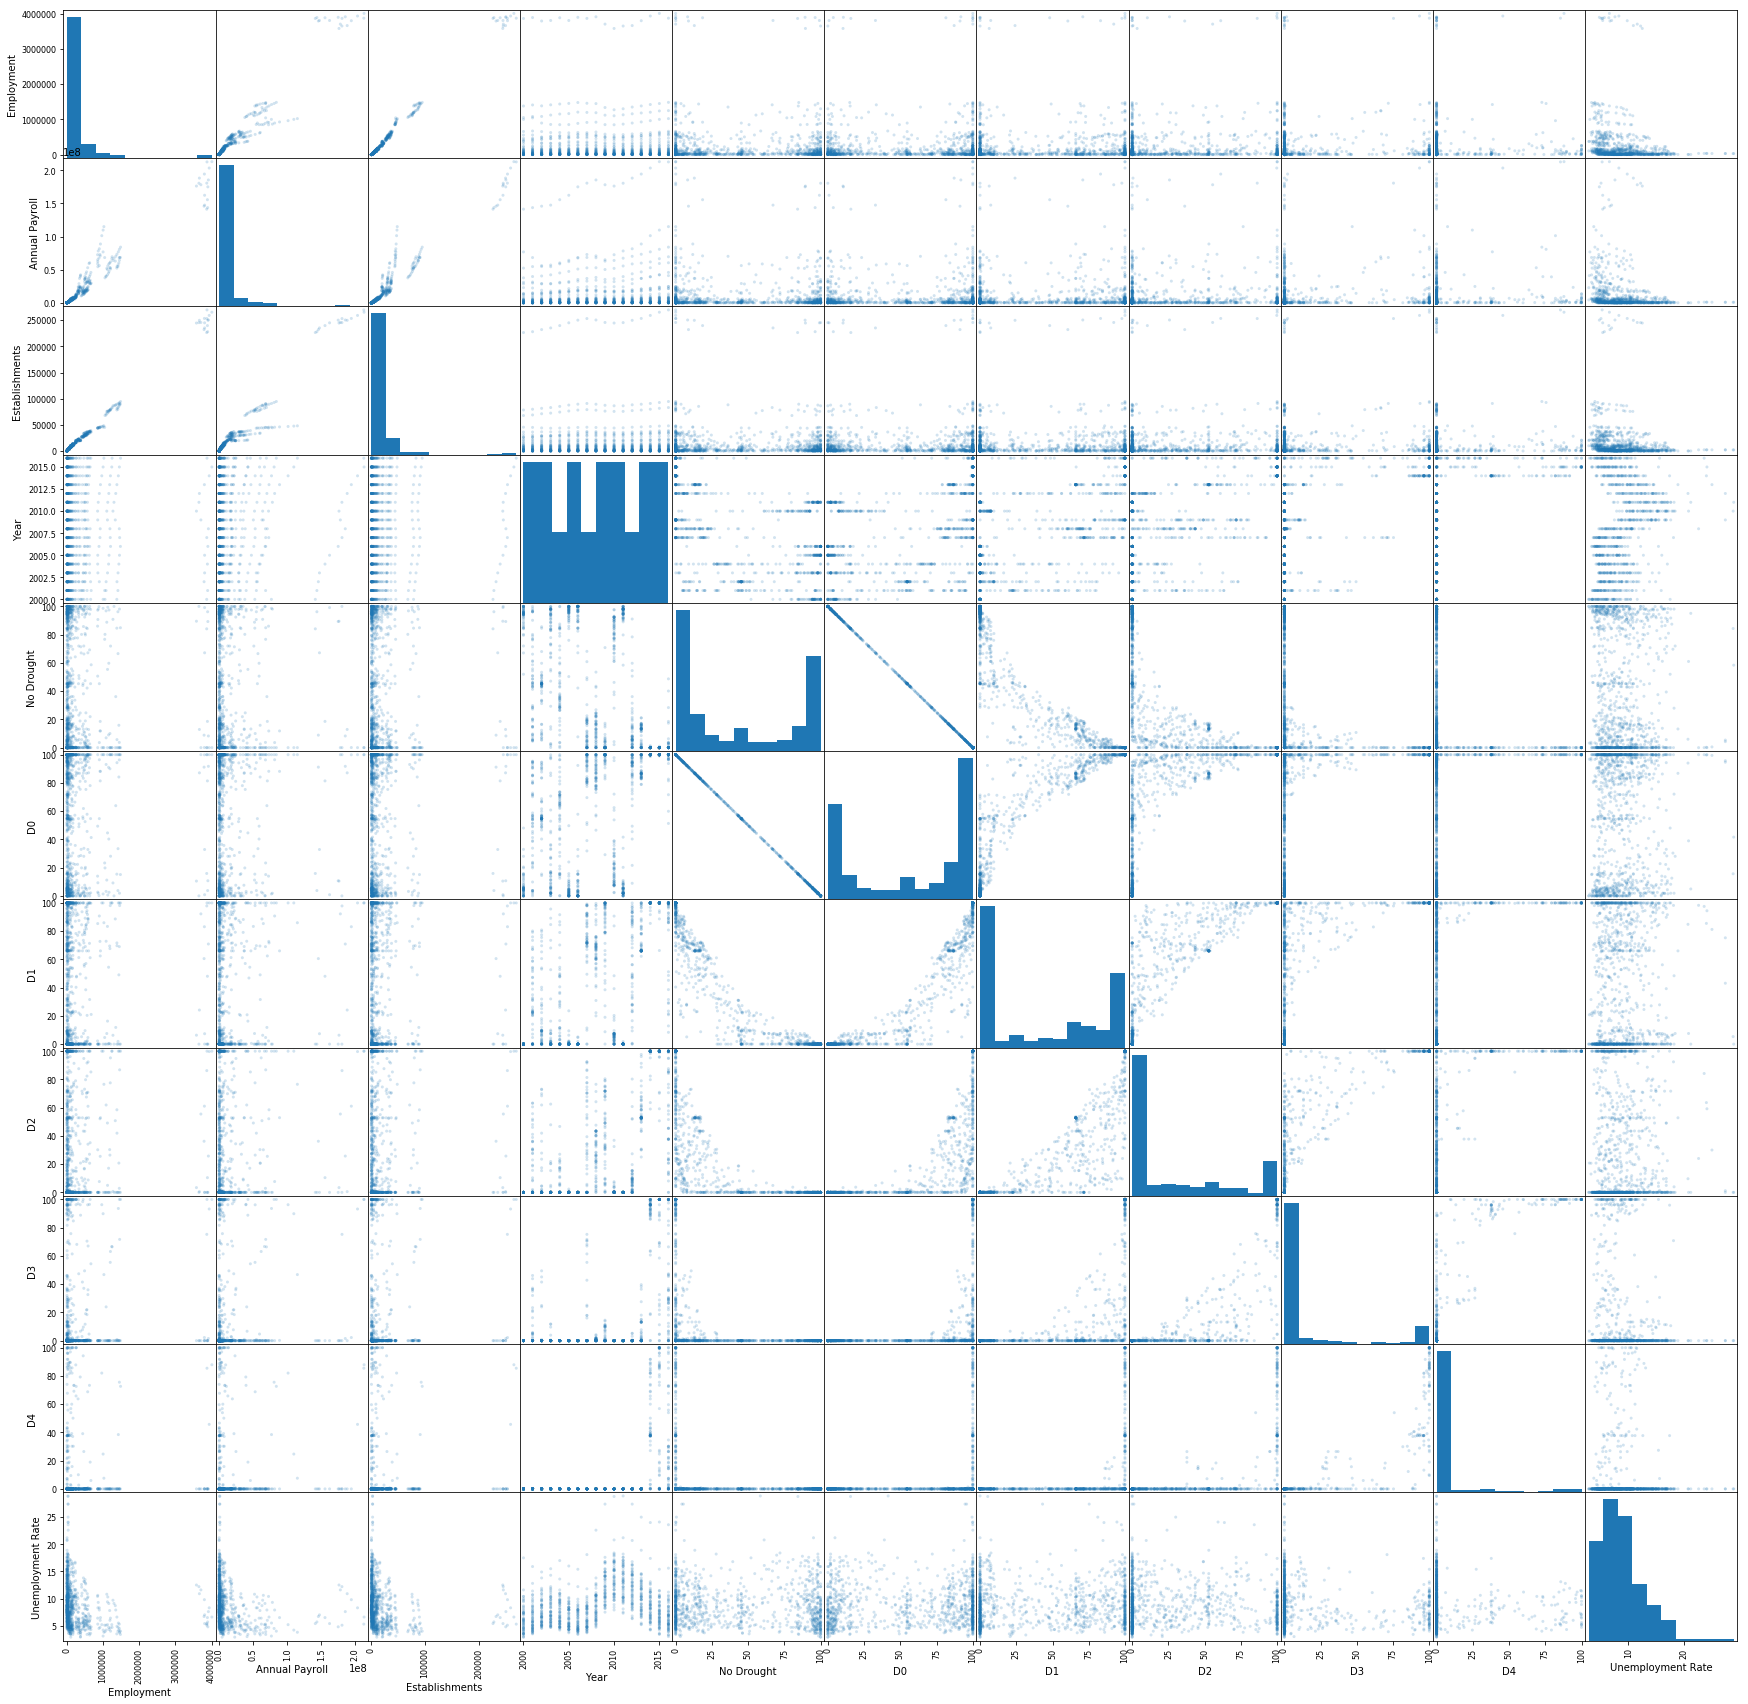

In [13]:
##Shape

#Making a list of column variables
col = list(project_df.columns.values)

#Change shape of the plot
scatter_matrix(project_df, alpha=0.2, figsize=(30, 30));

In [14]:
##Missing Values

#Checking the number of NaNs for each variable
ur = project_df['Unemployment Rate'].isna().sum()
emp = project_df['Employment'].isna().sum()
pay = project_df['Annual Payroll'].isna().sum()
esta = project_df['Establishments'].isna().sum()
nd = project_df['No Drought'].isna().sum()
d0 = project_df['D0'].isna().sum()
d1 = project_df['D1'].isna().sum()
d2 = project_df['D2'].isna().sum()
d3 = project_df['D3'].isna().sum()
d4 = project_df['D4'].isna().sum()

#Using above value to make a dictionary
mv = {'Employment': [emp], 
      'Unemployment Rate':[ur],
      'Annual Payroll':[ur],
      'Establishments':[esta],
      'No Drought':[nd],
      'D0':[d0],
      'D1':[d1],
      'D2':[d2],
      'D3':[d3],
      'D4':[d4]}

#Making & Outputting the table for number of missing values
mv_final = pd.DataFrame.from_dict(mv)
mv_final.rename(index={0:'Number of Missing Values'}, inplace='True')
mv_final.head()

,Employment,Unemployment Rate,Annual Payroll,Establishments,No Drought,D0,D1,D2,D3,D4
Number of Missing Values,0,0,0,0,0,0,0,0,0,0


In [23]:
## Missing Values

# consider using this, it is much simpler....
pd.DataFrame(project_df.isnull().sum()).rename(columns={0:'Number of Missing Values'})

,Number of Missing Values
FIPS,0
Employment,0
Annual Payroll,0
Establishments,0
Year,0
County,0
No Drought,0
D0,0
D1,0
D2,0


## Ethical Considerations

As the data for this research will only require looking at quantitative measures such as income values or disease rates, there will be no need for personal information if it presents itself. To best protect the privacy of the individuals we are collecting data from, all personal information not related to the data sets specifically (such as name or address of the household we are collecting utility data from) will be removed in the end results. We do not believe though that our question or datasets are invasive in nature and predict this will be of little occurrence if any. For our analyses, being aware of the racial inequalities present in low income communities is important. Before making any specific generalizations, we will make sure (if the data is available) that the ethnicities of households or individuals that are making up the census data are representative of the communities we are looking at. 

## Conclusions and Discussion